In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import features
import helpers
import plots

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data_folder = 'data/csv/'
data_files = [mice + ".smo.csv" for mice in helpers.mice_breeds["bxd_101"]][:1]

print(data_files)

days = [0, 1, 2, 3]
window_sizes = [2, 5, 10, 50, 100]
window_features = ["EEGv", "EMGv"]
test_size = 0.3
useRaw = False
dropBins = True
cat_matrix = True # True for neural net, any for random forest
standardize_df = False
balance = True
seed = 13

['10101.smo.csv']


In [3]:
# train and test on same mice
df = features.clean_data(data_folder, data_files, days, window_sizes, window_features, dropBins, useRaw, balance, standardize_df)
x_train, x_test, y_train, y_test, le = features.split_encode_scale_data(df, useRaw, test_size, seed, cat_matrix)

Balancing classes to 3695 samples per class (total: 11085)


# Neural Network

In [4]:
def baseline_model(input_dim, num_classes, lr=0.0001):
    model = Sequential()
    model.add(Dense(3, input_dim=input_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

    return model

model = baseline_model(x_train.shape[1], le.classes_.size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 135       
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

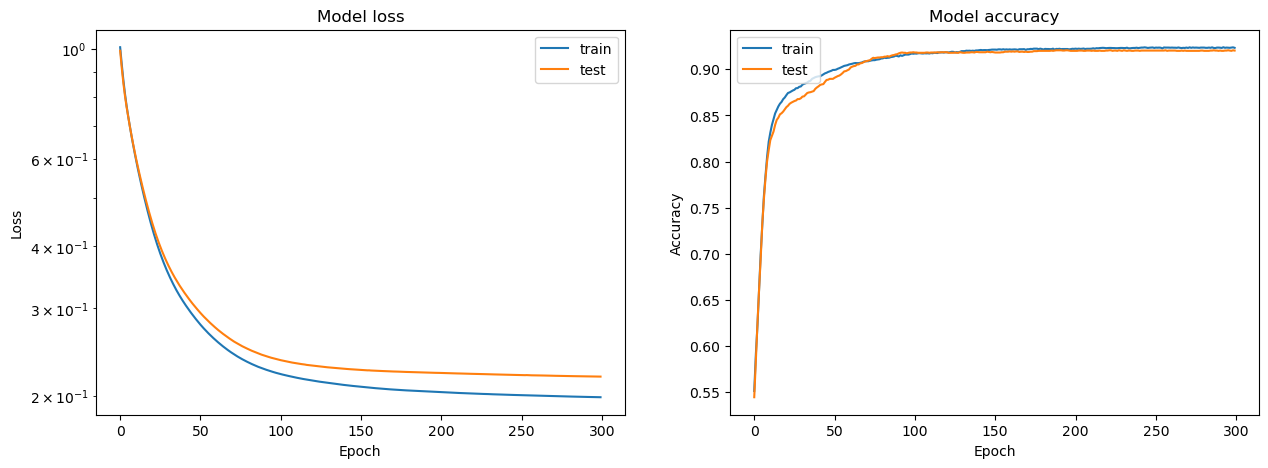

In [6]:
model = baseline_model(x_train.shape[1], le.classes_.size)
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=300,
                    batch_size=64,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_history(history.history)

104/104 [==============================] - 0s 578us/step
[[1010   76   19]
 [  91 1050   11]
 [  27   41 1001]]
              precision    recall  f1-score   support

           n       0.90      0.91      0.90      1105
           r       0.90      0.91      0.91      1152
           w       0.97      0.94      0.95      1069

    accuracy                           0.92      3326
   macro avg       0.92      0.92      0.92      3326
weighted avg       0.92      0.92      0.92      3326



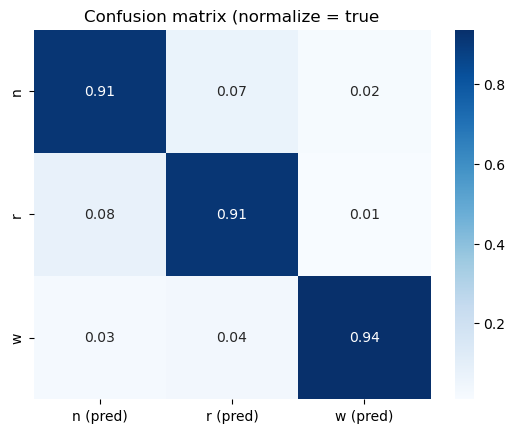

In [7]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold

x, y, le = features.split_encode_scale_data_kfold(df, useRaw, seed, cat_matrix=True)
model = baseline_model(x_train.shape[1], le.classes_.size)

kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x, y):
  model = baseline_model(x_train.shape[1], le.classes_.size)
  # Generate a print
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(x=x[train],
                    y=y[train],
                    epochs=300,
                    batch_size=64,
                    verbose=0,
                )

  # confusion matrix
  cm = np.zeros((le.classes_.size, le.classes_.size))
  cm = cm + plots.confusion(model=model, x_test=x[test], y_test=y[test], le=le, cat_matrix=True)
  # Increase fold number
  fold_no = fold_no + 1

confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')
sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true')
plt.show()

# Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)

plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')